## Figure 1D, 2D

In [1]:
from pynwb import NWBHDF5IO
from scipy.io import savemat, loadmat
import mat73
import hdf5storage as st
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import Isomap

from scipy.sparse.linalg import eigsh
from scipy.stats import wilcoxon, mannwhitneyu, sem, linregress
from scipy.spatial.distance import cdist

import seaborn as sns
from copy import deepcopy as dc
from statsmodels.stats.multitest import multipletests

from itertools import combinations, product
import math

# # tell pandas to show all columns when we display a DataFrame
# pd.set_option("display.max_columns", None)

In [2]:
# loading variables

# ABO Neuropixels
with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_RS_all = pickle.load(f)

    list_rate_RS = resp_matrix_ep_RS_all['list_rate_RS'].copy()
    list_rate_RS_dr = resp_matrix_ep_RS_all['list_rate_RS_dr'].copy()
    list_rate_all = resp_matrix_ep_RS_all['list_rate_all'].copy()
    list_rate_all_dr = resp_matrix_ep_RS_all['list_rate_all_dr'].copy()
    list_slopes_RS_an_loglog = resp_matrix_ep_RS_all['list_slopes_RS_an_loglog'].copy()
    list_slopes_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_all_an_loglog'].copy()
    list_slopes_stat_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_stat_all_an_loglog'].copy()
    list_slopes_mov_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_mov_all_an_loglog'].copy()

    sess_inds_qual_RS = resp_matrix_ep_RS_all['sess_inds_qual_RS'].copy()
    sess_inds_qual_RS_dr = resp_matrix_ep_RS_all['sess_inds_qual_RS_dr'].copy()
    sess_inds_qual_all = resp_matrix_ep_RS_all['sess_inds_qual_all'].copy()
    sess_inds_qual_all_dr = resp_matrix_ep_RS_all['sess_inds_qual_all_dr'].copy()

In [3]:
def annotate_lineplot_significance(significant_values, axes, ax_ind, line_height_ratio, color):

    if len(significant_values) > 0:

        # Initialize start and end points of lines
        start = None
        lines = []
        dots = []

        # Loop through sorted significant_values to group them into lines or dots
        for i in range(len(significant_values) - 1):
            if start is None:
                start = significant_values[i]

            # Check if the next value is part of the same line
            if significant_values[i + 1] - significant_values[i] > 0.1 + 1e-9:  # Threshold for a gap; add pseudo-value to avoid floating point issue
                if start == significant_values[i]:
                    dots.append(start)  # Isolated point
                else:
                    lines.append((start, significant_values[i]))  # Line segment
                start = None

        # Check the last value
        if start is None:
            dots.append(significant_values[-1])
        else:
            lines.append((start, significant_values[-1]))

        # Plot lines and dots
        for line in lines:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)  # Draw a line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
                
        for dot in dots:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)  # Draw a very short line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)

In [4]:
def compute_mean_var_trial(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1)
        trial_var = np.var(trial_rate, axis=1, ddof=1)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = pd.concat([trial_mean] * label_cnt_dict[trial_type], axis=1)
        list_trial_var[trial_ind] = pd.concat([trial_var] * label_cnt_dict[trial_type], axis=1)

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [5]:
def compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = trial_mean.copy()
        list_trial_var[trial_ind] = trial_var.copy()

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [6]:
# # Effective dimensionality (~7 min)

# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# num_trial_types = 119

# # Iterate over all sessions

# list_dim_asis = np.zeros((num_sess, num_trial_types))
# list_dim_RRneuron2 = np.zeros((num_sess, len(list_target_slopes), num_trial_types))
# for sess_ind, rate in enumerate(list_rate_all):
#     print(f'sess_ind: {sess_ind}')
    
#     rate_sorted = rate.sort_index(axis=1)
#     stm = rate_sorted.columns.copy()

#     # Multiply by delta t to convert to spike counts
#     rate_sorted = rate_sorted * 0.25 

#     # Create a counting dictionary for each stimulus
#     all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
#     stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

#     # Compute mean & variance for each stimulus
#     rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate_sorted)
#     rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate_sorted)

#     list_slopes_dr = pd.DataFrame(list_slopes_all_an_loglog[sess_ind], \
#                                     columns=rate_sorted_mean_coll.columns).copy()
    
#     # Prepare PCA
#     n_components = rate_sorted.shape[0]
#     pca = PCA(n_components=n_components)

#     # Compute effective dimensionality for each stimulus
#     for trial_type_ind, trial_type in enumerate(all_stm_unique):
#         cf = np.cov(rate_sorted.loc[:, trial_type])
#         list_dim_asis[sess_ind, trial_type_ind] = ((cf.trace())**2 / np.power(cf, 2).trace()) / rate_sorted.shape[0] # normalize by num_neurons to allow comparison across sessions

#     # Convert 0 to NaN (verified that cases of mean=0 and var=0 coincide exactly)
#     rate_sorted_mean_coll[rate_sorted_mean_coll == 0] = np.nan
#     rate_sorted_var_coll[rate_sorted_var_coll == 0] = np.nan

#     list_dim_RRneuron = np.zeros((len(list_target_slopes), num_trial_types))
#     for slope_ind, target_slope in enumerate(list_target_slopes):
#         print(f'target_slope = {target_slope:.1f}')

#         # calculate target variance
#         var_estim_dr = pd.DataFrame(np.zeros((1, rate_sorted_var_coll.shape[1])), \
#                                 columns=rate_sorted_var_coll.columns) 
#         for trial_type in rate_sorted_var_coll.columns:
#             var_estim_dr.loc[:, trial_type] = \
#                 np.nanmean(rate_sorted_var.loc[:, trial_type].values.flatten()) # nanmean
#         # var_estim_dr = np.repeat(var_estim_dr, all_stm_counts, axis=1) 
#         # print(var_estim_dr)

#         # offset = var_estim_dr.div(rate_sorted_var_coll.pow(target_slope/list_slopes_dr.iloc[0, :], axis=1).mean(axis=0))\
#         # .mul(pow(10, target_slope * list_slopes_dr.iloc[1, :] / list_slopes_dr.iloc[0, :])) # collapsed 
#         offset = pow(10, (list_slopes_dr.iloc[0, :]-target_slope) * np.nanmean(np.log10(rate_sorted_mean_coll), axis=0) + list_slopes_dr.iloc[1, :]) 

#         var_rs_noisy = \
#             pow(10, np.log10(rate_sorted_var_coll).sub(list_slopes_dr.iloc[1, :], axis=1)\
#                 .div(list_slopes_dr.iloc[0, :], axis=1).mul(target_slope).add(np.log10(np.array(offset)), axis=1)) # collapsed
#         var_rs_noisy = np.repeat(np.array(var_rs_noisy), all_stm_counts, axis=1) 

#         # Compute changed residual and add back to the mean            
#         rate_sorted_resid_dr = rate_sorted - rate_sorted_mean
#         # rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
#         #     .mul(np.sqrt(rate_sorted_mean)).mul(np.sqrt(FF_estim_dr), axis=1)
#         rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
#             .mul(np.sqrt(var_rs_noisy))
#         # print(rate_resid_RRneuron_dr)
#         rate_RRneuron_dr = rate_sorted_mean + rate_resid_RRneuron_dr
#         rate_RRneuron_dr[rate_RRneuron_dr.isna()] = 0 # convert NaN to 0! 

#         # Compute mean and variance of slope-changed data
#         rate_mean_RRneuron_coll, rate_var_RRneuron_coll = \
#             compute_mean_var_trial_collapse(stm_cnt_dict, rate_RRneuron_dr)
#         # FF_RRneuron = rate_var_RRneuron_dr.div(rate_mean_RRneuron_dr)
#         # print(FF_RRneuron)
#         # print(rate_var_RRneuron_dr)
        
#         # 1. use covariance matrix
        
#         # Compute effective dimensionality for each stimulus
#         for trial_type_ind, trial_type in enumerate(all_stm_unique):
#             cf = np.cov(rate_RRneuron_dr.loc[:, trial_type])
#             list_dim_RRneuron[slope_ind, trial_type_ind] = ((cf.trace())**2 / np.power(cf, 2).trace()) / rate_RRneuron_dr.shape[0] # normalize by num_neurons to allow comparison across sessions

#         # # 2. use eigenvalue
#         # for trial_type_ind, trial_type in enumerate(all_stm_unique):
#         #     rate_RRneuron_pca = pca.fit_transform(rate_RRneuron_dr.loc[:, trial_type].T).T            
#         #     list_dim_RRneuron[slope_ind, trial_type_ind] = (np.sum(pca.explained_variance_))**2 / np.sum(pca.explained_variance_**2)

#         list_dim_RRneuron2[sess_ind] = list_dim_RRneuron.copy()

In [7]:
# # Save effective dimensionality
# with open('eff_dim_DC_ABO.pickle', 'wb') as f:
#     pickle.dump({'tree_variables': ['list_dim_asis', 'list_dim_RRneuron2'], 'list_dim_asis': list_dim_asis, 'list_dim_RRneuron2': list_dim_RRneuron2}, f)

## Figure 1D

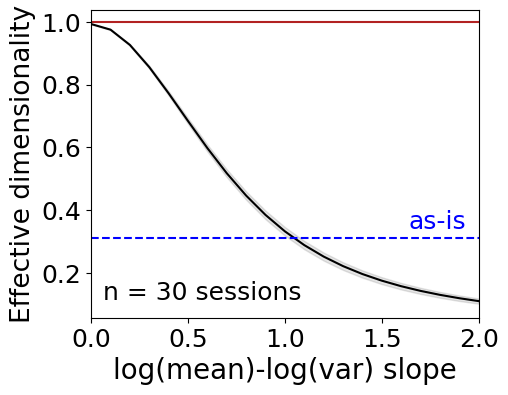

In [8]:
# effective dimensionality plot

save_file_name = 'eff_dim_ABO.pickle'
save_file_name = 'eff_dim_DC_ABO.pickle'
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    eff_dim_ABO = pickle.load(f)

    list_dim_asis = eff_dim_ABO['list_dim_asis'].copy()
    list_dim_RRneuron2 = eff_dim_ABO['list_dim_RRneuron2'].copy()

# Exclude low quality sessions (0, 6)
list_dim_asis = np.concatenate([list_dim_asis[1:6], list_dim_asis[7:]], axis=0)
list_dim_RRneuron2 = np.concatenate([list_dim_RRneuron2[1:6], list_dim_RRneuron2[7:]], axis=0)

# line plot

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# Wilcoxon signed-rank test (across sessions)
list_pvals_dim_ABO = np.zeros(len(list_target_slopes))
for slope_ind, target_slope in enumerate(list_target_slopes):
    list_pvals_dim_ABO[slope_ind] = list(wilcoxon(np.nanmean(list_dim_asis, axis=1),
                                                  np.nanmean(list_dim_RRneuron2[:, slope_ind], axis=1), nan_policy='omit'))[1]
list_sig_slopes_dim = list_target_slopes[list_pvals_dim_ABO < 0.05].copy()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

list_means_dim = np.nanmean(list_dim_RRneuron2, axis=(0, 2))
list_errs_dim = sem(np.nanmean(list_dim_RRneuron2, axis=2), axis=0)

ax.plot(list_target_slopes, list_means_dim, color='k')
ax.fill_between(list_target_slopes, list_means_dim-list_errs_dim, list_means_dim+list_errs_dim, color='k', alpha=0.1)

ax.axhline(np.nanmean(list_dim_asis), color='b', linestyle='--') # as-is average

# significance
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
annotate_lineplot_significance(list_sig_slopes_dim, axes=None, ax_ind=None, line_height_ratio=0.96, color='firebrick')
height = (np.nanmean(list_dim_asis)-ax.get_ylim()[0]) / (ax.get_ylim()[1]-ax.get_ylim()[0])
ax.annotate('as-is', xy=(0.82, height+0.03), xycoords='axes fraction', fontsize=18, color='b')
ax.annotate(f'n = {list_dim_asis.shape[0]} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=18, color='k')

ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
ax.set_ylabel('Effective dimensionality', fontsize=19)
ax.tick_params('both', labelsize=18)

ax.set_xlim(0, 2)

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\effdim.svg', bbox_inches='tight')
plt.show()

In [9]:
# # Collect tangent angle for each session

# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)
# # list_target_slopes = [0, 1, 2]

# num_sess = 32
# num_trial_types = 119
# n_neighbors = 5 # knn

# # list_angles_asis2 = np.full((num_sess, num_trial_types, n_neighbors), np.nan)
# # list_angles_RRneuron3 = np.full((num_sess, len(list_target_slopes), num_trial_types, n_neighbors), np.nan)
# list_angles_asis2 = np.full((num_sess, num_trial_types), np.nan)
# list_angles_RRneuron3 = np.full((num_sess, len(list_target_slopes), num_trial_types), np.nan)
# # list_angles_asis2 = np.full(num_sess, np.nan)
# # list_angles_RRneuron3 = np.full((num_sess, len(list_target_slopes)), np.nan)
# for sess_ind in range(num_sess):
    
#     # if sess_ind != 0 and sess_ind != 6: 
#     # if sess_ind == 1:
#         file_name = 'tangent_angles_ABO_' + str(sess_ind) + '.pickle'
        
#         with open(file_name, 'rb') as f:
#             tangent_angles_ABO = pickle.load(f)
#             list_angles_asis2[sess_ind] = tangent_angles_ABO['list_angles_asis'].copy()
#             list_angles_RRneuron3[sess_ind] = tangent_angles_ABO['list_angles_RRneuron2'].copy()

# save_file_name = 'tangent_angles_ABO_all38.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_angles_asis2', 'list_angles_RRneuron3'],
#                                     'list_angles_asis2': list_angles_asis2, 'list_angles_RRneuron3': list_angles_RRneuron3}, f)

## Figure 2D right

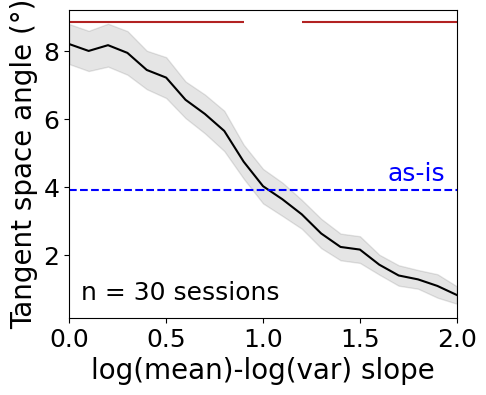

In [10]:
save_file_name = 'tangent_angles_ABO_all38.pickle' # Slope 0-2 & posterior to midline, candidates: 25 (farthest by geodesic) & 25%, radius 90%, closest pair 50%
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    tangent_angles_ABO_all = pickle.load(f)

    list_angles_asis2 = tangent_angles_ABO_all['list_angles_asis2'].copy()
    list_angles_RRneuron3 = tangent_angles_ABO_all['list_angles_RRneuron3'].copy()

list_angles_asis2 = np.degrees(list_angles_asis2) 
list_angles_RRneuron3 = np.degrees(list_angles_RRneuron3)

# Exclude low quality sessions (0, 6)
list_angles_asis2 = np.concatenate([list_angles_asis2[1:6], list_angles_asis2[7:]], axis=0)
list_angles_RRneuron3 = np.concatenate([list_angles_RRneuron3[1:6], list_angles_RRneuron3[7:]], axis=0)

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# Wilcoxon signed-rank test
list_pvals_angles = np.zeros(len(list_target_slopes))
for slope_ind, target_slope in enumerate(list_target_slopes):
    list_pvals_angles[slope_ind] = list(wilcoxon(np.nanmean(list_angles_asis2, axis=1),
                                                 np.nanmean(list_angles_RRneuron3[:, slope_ind], axis=1), nan_policy='omit'))[1]
    
list_sig_slopes_angles = list_target_slopes[list_pvals_angles < 0.05].copy()
# print(f'significant slope: {list_sig_slopes_angles}')

num_sess = 32
num_trial_types = 119

# line plot
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

list_means_angles = np.nanmean(list_angles_RRneuron3, axis=(0, 2))
list_errs_angles = sem(np.nanmean(list_angles_RRneuron3, axis=2), axis=0, nan_policy='omit')

axes[0].plot(list_target_slopes, list_means_angles, color='k')
axes[0].fill_between(list_target_slopes, list_means_angles-list_errs_angles, list_means_angles+list_errs_angles,
                color='k', alpha=0.1)

axes[0].axhline(np.nanmean(list_angles_asis2), color='blue', linestyle='--') # as-is average

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
# axes[0].set_ylim(0, 11)
annotate_lineplot_significance(list_sig_slopes_angles, axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')
height = (np.nanmean(list_angles_asis2)-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.82, height+0.03), xycoords='axes fraction', fontsize=18, color='blue')
axes[0].annotate(f'n = {list_angles_asis2.shape[0]} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=18, color='k')

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=20)
axes[0].set_ylabel('Tangent space angle (°)', fontsize=20)
axes[0].tick_params('both', labelsize=18)

axes[0].set_xlim(0, 2)

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\tangent.svg', bbox_inches='tight')
plt.show()